In [1]:
using InteractiveUtils, Pkg, Revise
versioninfo(); Pkg.status()

Julia Version 1.6.7
Commit 3b76b25b64 (2022-07-19 15:11 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, cascadelake)
Environment:
  JULIA_NUM_THREADS = 4
      Status `/mnt/efs/kai/projects/AdvancedHMC.jl/research/tests/Project.toml`
  [c75e803d] AdaptiveRejectionSampling v0.1.1
  [0bf59076] AdvancedHMC v0.4.0 `../..#kx/rhmc-draft`
  [863f3e99] Comonicon v1.0.4
  [31c24e10] Distributions v0.24.18
  [366bfd00] DynamicPPL v0.10.20
  [6a86dc24] FiniteDiff v2.17.0
  [6d524b87] MCMCDebugging v0.2.0
  [91a5bcdd] Plots v1.38.6
  [d330b81b] PyPlot v2.11.1
  [e0db7c4e] ReTest v0.3.2
  [37e2e3b7] ReverseDiff v1.9.0
  [8a639fad] VecTargets v0.2.0 `https://github.com/xukai92/VecTargets.jl#main`


In [2]:
using Statistics, AdvancedHMC
includet("../src/riemannian_hmc.jl")
includet("../src/riemannian_hmc-sampler.jl")

┌ Warning: skipping callee #step#10 (called by step) due to UndefRefError()
└ @ LoweredCodeUtils /home/kai/.julia/packages/LoweredCodeUtils/0oUEK/src/signatures.jl:292


Neal's funnel

Progress: 100%|█████████████████████████████████████████| Time: 0:01:52


149.615140 seconds (919.58 M allocations: 57.238 GiB, 9.70% gc time, 0.00% compilation time)
Quantile error: 0.00859


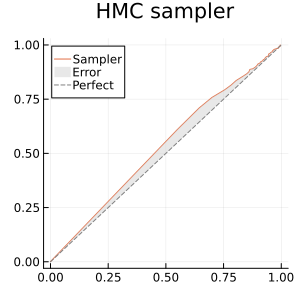

In [3]:
using Distributions, DynamicPPL

# Treating the first 2 dimensions as latent and the third as data.
@model function TuringFunnel(θ=missing, x=missing)
    if ismissing(θ)
        θ = Vector(undef, 2)
    end
    θ[1] ~ Normal(0, 3)
    s = exp(θ[1] / 2)
    θ[2] ~ Normal(0, s)
    x ~ Normal(0, s)
    return θ, x
end

# Sanity check for normal HMC
function rand_θ_given_hmc(target, hps, x_data; seed=rand(UInt32))
    rng = MersenneTwister(seed)
    
    D = dim(target) - 1
    θ₀ = rand(rng, D)
    
    ℓπ = x -> logpdf(target, vcat(x, x_data))
    ∂ℓπ∂θ = VecTargets.gen_grad(ℓπ, θ₀)

    metric = DenseEuclideanMetric(D)
    kinetic = GaussianKinetic()
    hamiltonian = Hamiltonian(metric, kinetic, ℓπ, ∂ℓπ∂θ)

    TS = EndPointTS
    
    integrator = GeneralizedLeapfrog(hps.ϵ, hps.n)

    tc = FixedNSteps(hps.L)
    
    proposal = HMCKernel(Trajectory{TS}(integrator, tc))

    samples, stats = sample(
        rng, hamiltonian, proposal, θ₀, hps.n_samples; progress=false, verbose=true
    )
    
    return samples[end]
end

make_rand_θ_given_hmc(hps, target) = x -> rand_θ_given_hmc(hps, target, x)

g(θ, x) = cat(θ, x; dims=1)

using MCMCDebugging
using Logging: NullLogger, with_logger

hps_geweke = (; n_samples=100, λ=1e-2, α=20.0, ϵ=0.1, n=6, L=8)

@time res = with_logger(NullLogger()) do
    perform(GewekeTest(1000), TuringFunnel, make_rand_θ_given_hmc(Funnel(3), hps_geweke); g=g)
end

using Plots: Plots

Plots.plot(res, TuringFunnel(); size=(300, 300), title="HMC sampler")

In [ ]:
# I still need to use the hand-written one because of AD
function rand_θ_given(hps, target, x_data; seed=rand(UInt32))
    rng = MersenneTwister(seed)
    
    D = dim(target) - 1
    θ₀ = rand(rng, D)
    
    ℓπ = x -> logpdf(target, vcat(x, x_data))
    ∂ℓπ∂θ = VecTargets.gen_grad(ℓπ, θ₀)
    
    _, _, Gfunc, ∂G∂θfunc = prepare_sample_target(hps, θ₀, ℓπ)

    metric = DenseRiemannianMetric((D,), Gfunc, ∂G∂θfunc, SoftAbsMap(hps.α))
    kinetic = GaussianKinetic()
    hamiltonian = Hamiltonian(metric, kinetic, ℓπ, ∂ℓπ∂θ)

    TS = EndPointTS
    
    integrator = GeneralizedLeapfrog(hps.ϵ, hps.n)

    tc = FixedNSteps(hps.L)
    
    proposal = HMCKernel(Trajectory{TS}(integrator, tc))

    samples, stats = sample(
        rng, hamiltonian, proposal, θ₀, hps.n_samples; progress=false, verbose=true
    )
    
    return samples[end]
end

make_rand_θ_given(hps, target) = x -> rand_θ_given(hps, target, x)

hps_geweke = (; n_samples=100, λ=1e-2, α=20.0, ϵ=0.1, n=6, L=8)

@time res_1 = with_logger(NullLogger()) do 
    perform(GewekeTest(1000), TuringFunnel, make_rand_θ_given(hps_geweke, Funnel(3)); g=g)
end

Progress:  30%|████████████▎                            |  ETA: 1:01:23

Quantile error: 0.00485


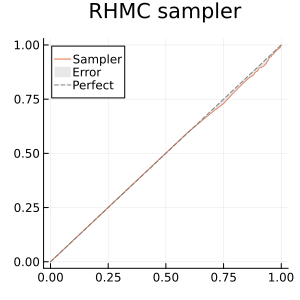

In [13]:
Plots.plot(res_1, TuringFunnel(); size=(300, 300), title="RHMC sampler")

In [ ]:
hps_geweke = (; hps_geweke..., n=12)

@time res_2 = with_logger(NullLogger()) do 
    perform(GewekeTest(1000), TuringFunnel, make_rand_θ_given(hps_geweke, Funnel(3)); g=g)
end

Quantile error: 0.011109999999999998


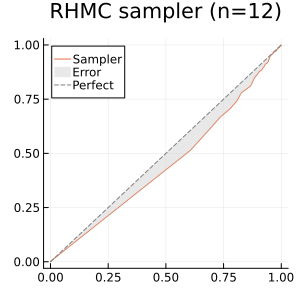

In [14]:
Plots.plot(res_2, TuringFunnel(); size=(300, 300), title="RHMC sampler (n=12)")

A simpler target

In [ ]:
using VecTargets: ContinuousMultivariateDistribution, _logpdf_normal
import VecTargets: dim, logpdf

struct SimpleTarget <: ContinuousMultivariateDistribution end

dim(st::SimpleTarget) = 3

function _logpdf_st(θx::AbstractVecOrMat)
    θ1, θ2, x = θx[1,:], θx[2,:], θx[3,:]
    s = 1

    lp11 = _logpdf_normal(θ1, 0, s) # _logpdf_normal(x, m, s)
    lp12 = _logpdf_normal(θ2, 0, s)
    lp2 = _logpdf_normal(x, θ1, s)
    
    return lp11 + lp12 + lp2
end

logpdf(::SimpleTarget, θ::AbstractVector) = only(_logpdf_st(θ))

logpdf(::SimpleTarget, θ::AbstractMatrix) = _logpdf_st(θ)

# Treating the first 2 dimensions as latent and the third as data.
@model function TuringSimple(θ=missing, x=missing)
    if ismissing(θ)
        θ = Vector(undef, 2)
    end
    θ[1] ~ Normal(0, 1)
    θ[2] ~ Normal(0, 1)
    x ~ Normal(θ[1], 1)
    return θ, x
end

hps_geweke = (; n_samples=100, λ=1e-2, α=20.0, ϵ=0.1, n=6, L=8)

@time res = with_logger(NullLogger()) do
    perform(GewekeTest(1000), TuringSimple, make_rand_θ_given_hmc(SimpleTarget(), hps_geweke); g=g)
end

Plots.plot(res, TuringSimple(); size=(300, 300), title="HMC sampler")

In [ ]:
hps_geweke = (; n_samples=100, λ=1e-2, α=20.0, ϵ=0.1, n=6, L=8)

@time res_3 = with_logger(NullLogger()) do 
    perform(GewekeTest(1000), TuringSimple, make_rand_θ_given(hps_geweke, SimpleTarget()); g=g)
end

Quantile error: 0.025529999999999994


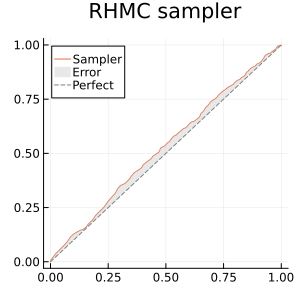

In [15]:
Plots.plot(res_3, TuringSimple(); size=(300, 300), title="RHMC sampler")

In [ ]:
hps_geweke = (; hps_geweke..., n=12)

@time res_4 = with_logger(NullLogger()) do 
    perform(GewekeTest(1000), TuringSimple, make_rand_θ_given(hps_geweke, SimpleTarget()); g=g)
end

Quantile error: 0.0058699999999999985


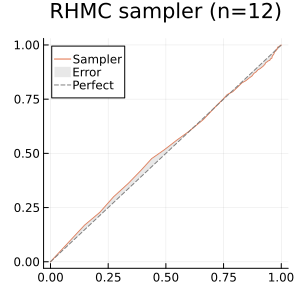

In [16]:
Plots.plot(res_4, TuringFunnel(); size=(300, 300), title="RHMC sampler (n=12)")